In [27]:
import chromatix.functional as cf
import jax.numpy as jnp
from sample import single_bead_sample 
from jax import Array

import matplotlib.pyplot as plt
from tensor_tomo import thick_polarised_sample
import jax

%config InlineBackend.figure_format='retina'

In [28]:
def run_sim(orientation: Array) -> tuple[Array, Array]:
    # Our input field is a plane wave
    shape = (5 * 90, 5 * 90) # sample size
    spacing = 0.065 # from paper
    wavelength = 0.405 # from paper
    n_m = 1.33
    polarisation = cf.linear(0) # x-polarised light
    n_bead = jnp.array([1.44, 1.40, 1.37])  # z y x
    bead_radius = 1.5
    k0 = 2 * jnp.pi / wavelength  # mum
    sample_shape = (4.55 // spacing, (11.7 / 2) // spacing, (11.7 / 2) // spacing)  # z y x # / 2 as we have only 1 bead
  
    # Making incoming field
    in_field = cf.plane_wave(shape, spacing, wavelength, 1.0, amplitude=polarisation, scalar=False, pupil=lambda f: cf.square_pupil(f, w =90*spacing), power=100)
    in_field = in_field.replace(u=in_field.u * jnp.sqrt(jnp.exp(-jnp.sum(in_field.grid**2, axis=0) / (2 * 1.0**2)))) # gaussian 
    
    # Making sample
    sample = single_bead_sample(n_m, n_bead, orientation, bead_radius, sample_shape, spacing, k0, antialiasing=1)
    print(jnp.linalg.norm(sample[35, 45, 45]))
    sample = cf.center_pad(sample, (0, 180, 180, 0, 0))    # Padding sample 

    # Running simulation
    field = thick_polarised_sample(in_field, sample, n_m, dz=spacing)

    print(in_field.power.squeeze(), field.power.squeeze())
    # Making plotting a little easier
    # ::-1 to invert y axis
    amplitude = field.amplitude.squeeze()
    amplitude = amplitude[::-1][180:-180, 180:-180]

    phase = field.phase.squeeze()
    phase = phase[::-1][180:-180, 180:-180]

    return amplitude, phase

In [29]:
# Getting all orientations
amplitude, phase = zip(*[run_sim(orientation) for orientation in [jnp.array([0, jnp.pi/2, 0]), jnp.array([0, 0, 0]), jnp.array([0, 0, jnp.pi/2]), jnp.array([jnp.pi/4, jnp.pi/4, jnp.pi/4])]])

90.38537
18.233751 18.381693
90.38537
18.233751 14.882038
90.38537
18.233751 14.871285
90.3854
18.233751 17.17454


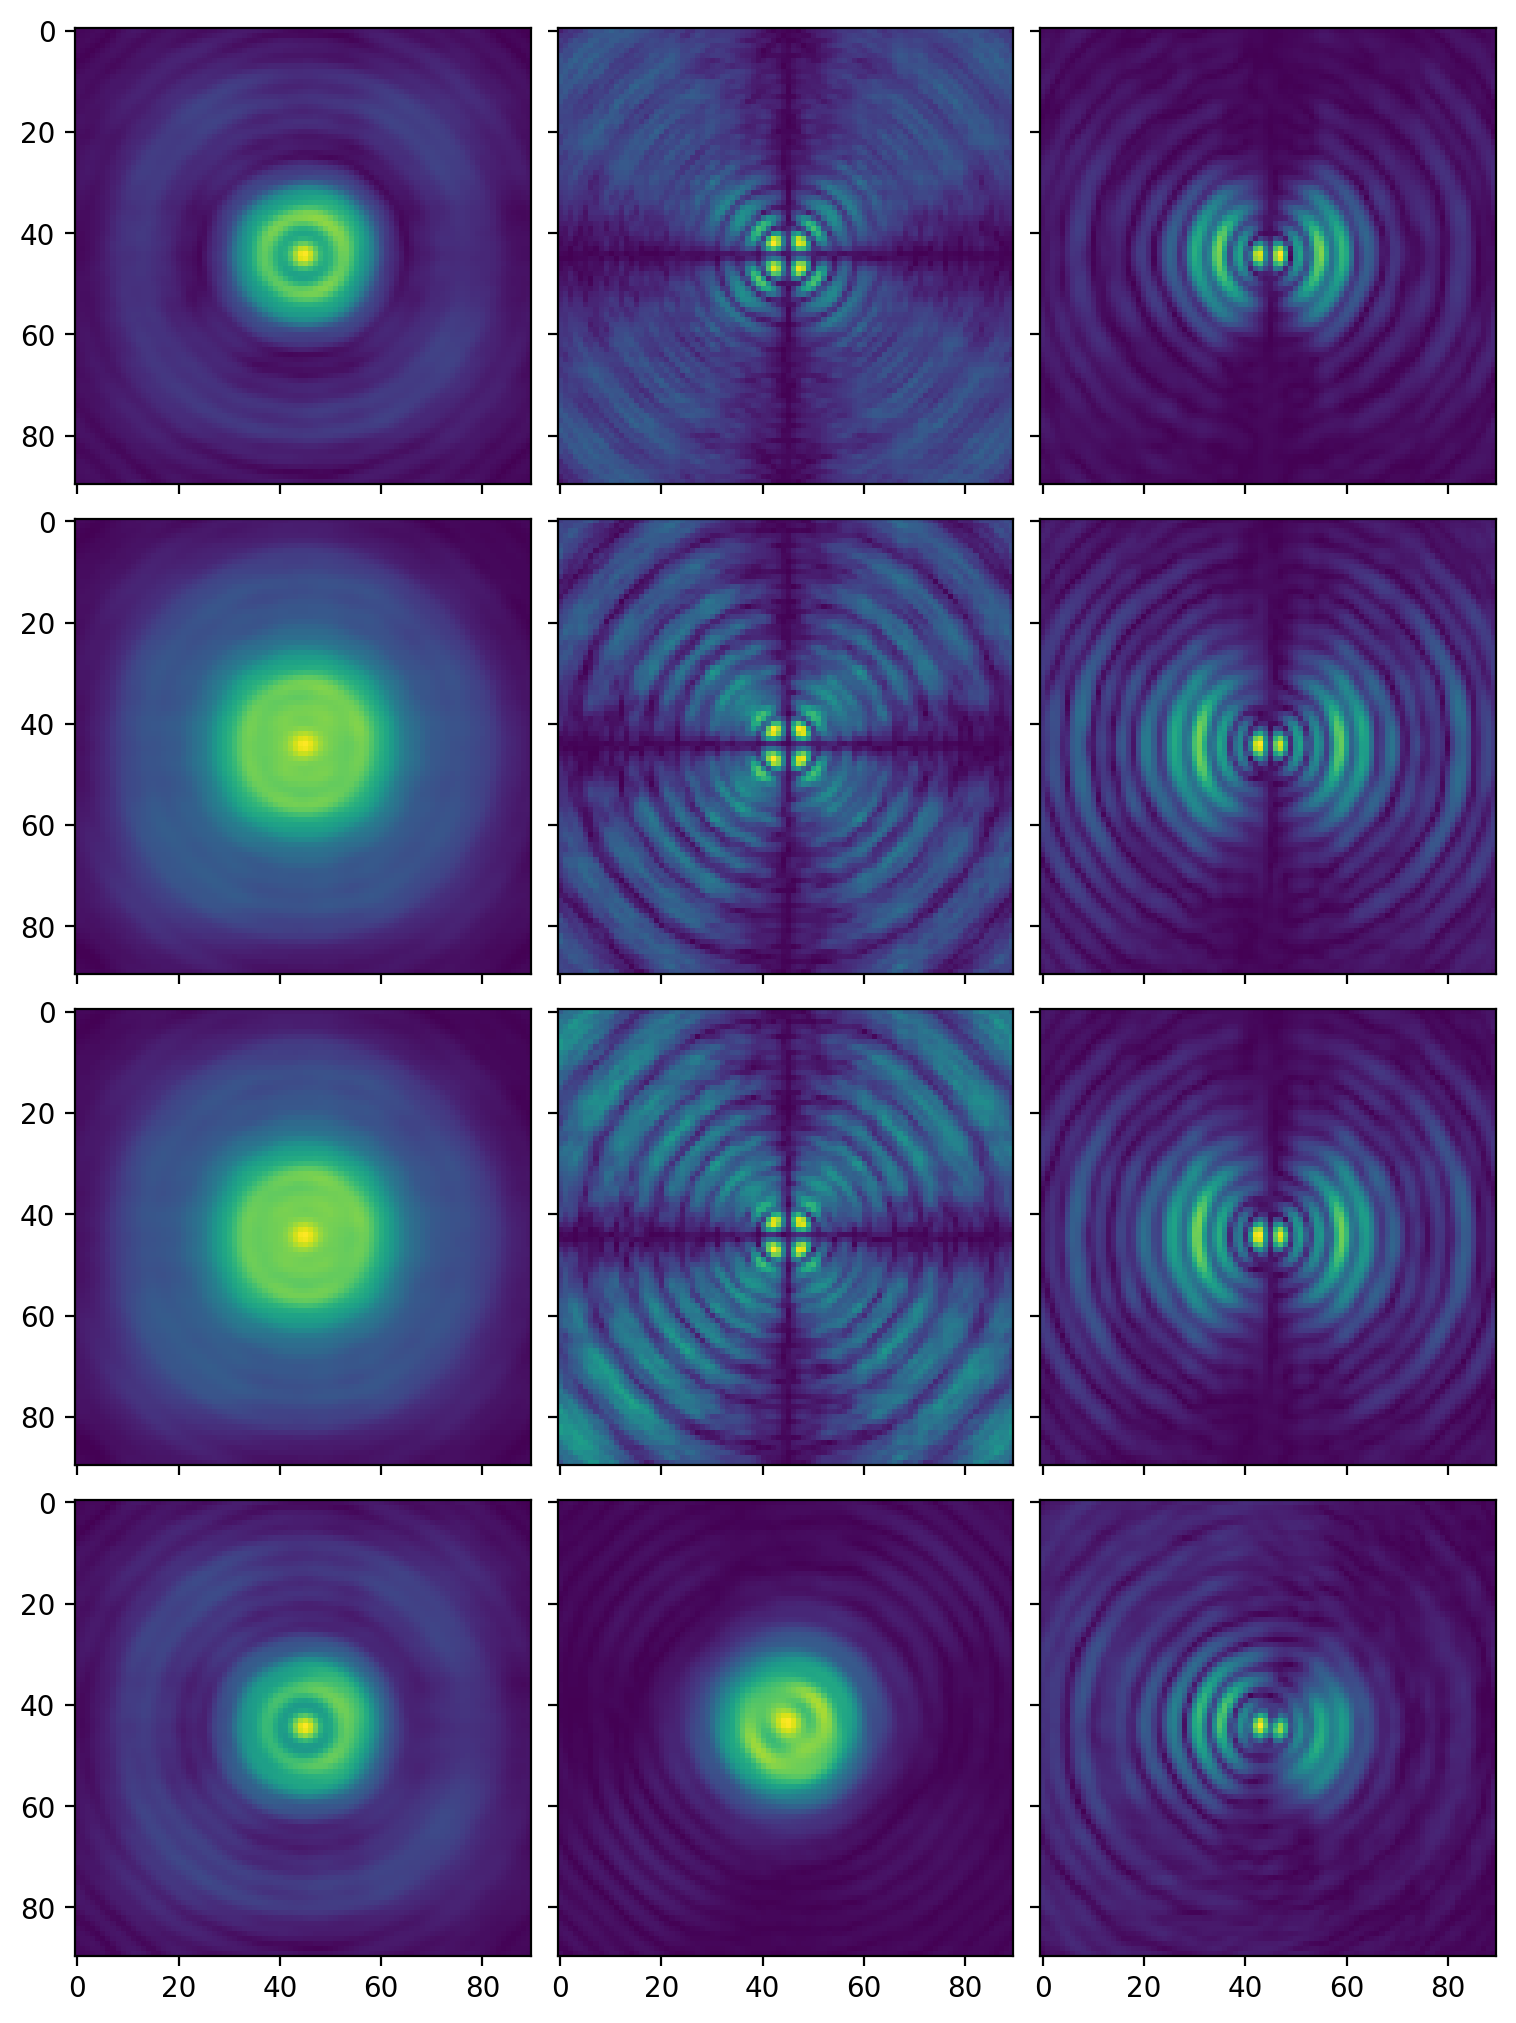

In [30]:
fig, axes = plt.subplots(ncols=3, nrows=4, layout="compressed", sharex=True, sharey=True, figsize=(13, 10))
#vmax = [2.5, 0.5, 1.0]
for idx_y in range(4):
    for idx_x in range(3):
        ax = axes[idx_y, idx_x]
        im = ax.imshow(amplitude[idx_y][..., 2 - idx_x])#, vmin=0, vmax = vmax[idx_x])

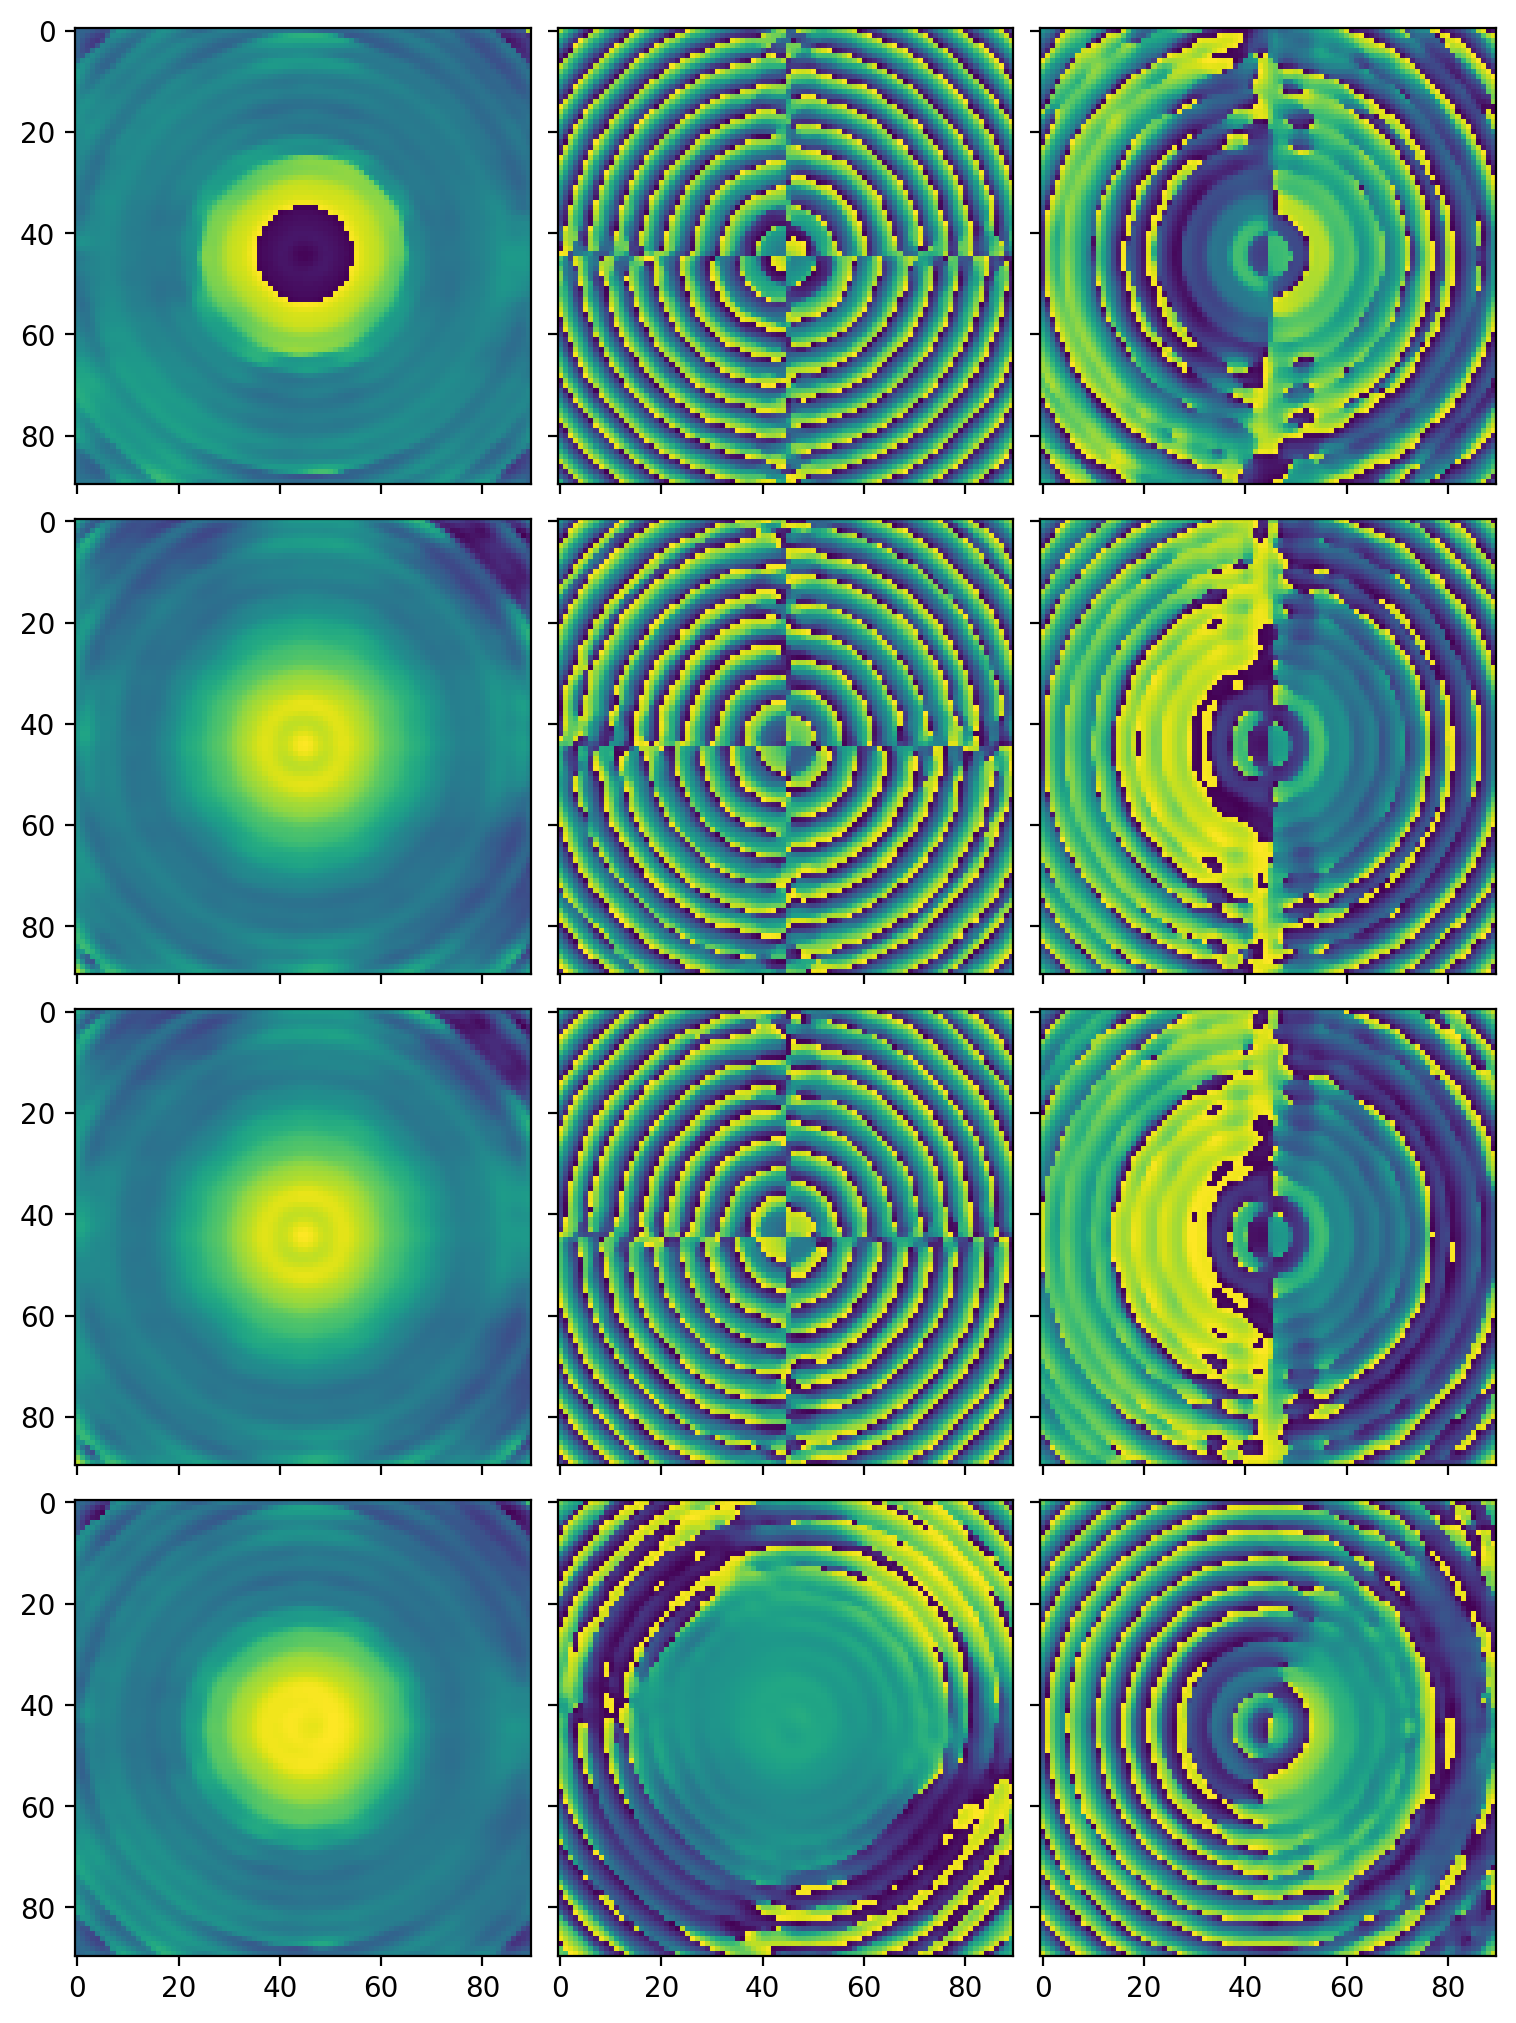

In [31]:
fig, axes = plt.subplots(ncols=3, nrows=4, layout="compressed", sharex=True, sharey=True, figsize=(13, 10))

for idx_y in range(4):
    for idx_x in range(3):
        ax = axes[idx_y, idx_x]
        im = ax.imshow(phase[idx_y][..., 2 - idx_x])

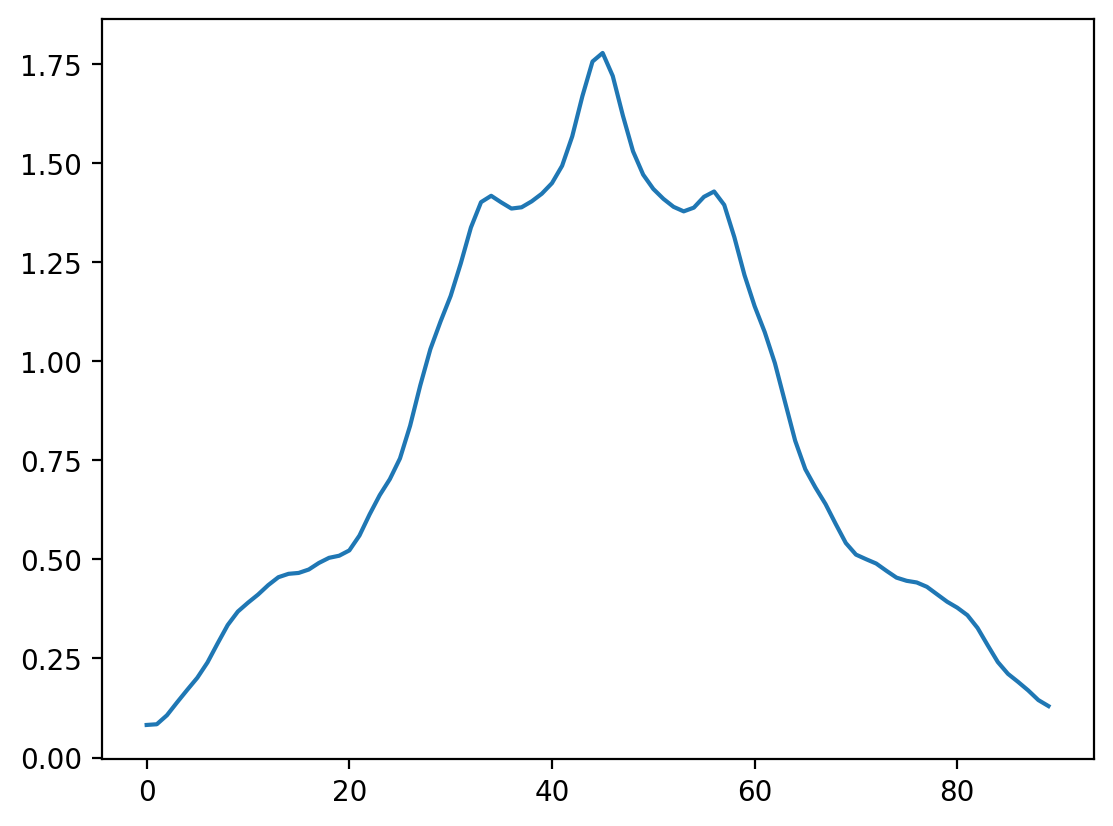

In [35]:
plt.plot(amplitude[1][45, :, 2])

In [34]:
amplitude[1].shape

(90, 90, 3)